[Chapter 8] Testing Set Overfitting

In [23]:
import numpy as np
import pandas as pd

from scipy.stats import norm, percentileofscore

import matplotlib.pyplot as plt

false strategy theorem

In [17]:
def getExpectedMaxSR(nTrials, meanSR, stdSR):
    """"
    compute expected max Sharpe Ratio, controlled for SBuMT(Selection Bias under Multiple Testing, which tends to inflate SR)
    based on false strategy theorem
    """
    
    emc = 0.577215664901532860606512090082402431042159336 # Euler-Mascheroni constant
    sr0 = (1-emc)*norm.ppf(1-1./nTrials) + emc*norm.ppf(1-(nTrials*np.e)**-1)
    sr0 = meanSR + stdSR*sr0

    return sr0

#-------------------------------------------------------------------------------------------

def getDistMaxSR(nSims, nTrials, stdSR, meanSR):
    """
    perform monte Carlo simulation to estimate the distribution of the maximum Sharpe Ratio (max{SR}) 
    on nTrials, from nSims simulations
    """
    rng = np.random.RandomState()
    out = pd.DataFrame()
    for nTrials_ in nTrials:

        # simulated sharpe ratios
        # nSims × nTrials_ matrix of random numbers from a standard normal distribution (mean=0, std=1)
        # each row is a simulation, each column a trial.
        sr = pd.DataFrame(rng.randn(nSims, nTrials_))
        # normalization (to make each row strictly follow standard normal distribution)
        # sr = sr - sr.mean
        sr = sr.sub(sr.mean(axis=1), axis=0) # center
        # sr = (sr - sr.mean) / sr.std
        sr = sr.div(sr.std(axis=1), axis=0) # scale
        # transform the normalized value to sharpe ratio sr ~ N(meanSR, stdSR^2)
        sr = meanSR + sr*stdSR

        # store output
        # find the maximum SR in each simulation (row) and store it in df 'max{SR}'
        out_ = sr.max(axis=1).to_frame('max{SR}')
        # also record the according number of trials used.
        out_['nTrials'] = nTrials_
        out = pd.concat([out, out_], ignore_index=True)

    return out

#---------------------------------------------------------------------------------------------

if __name__=='__main__':
    # generate 10 trial counts (nTrials) ranging from 10^1 to 10^6 on log scale
    # covert to int and set to remove duplicate
    # adjust logspace(1,6,1000) to logspace(1,2,100) due to hardware contraints
    nTrials = list(set(np.logspace(1,2,100).astype(int)))
    nTrials.sort()
    # compute the theoretical expected maximum SR for each nTrials
    sr0 = pd.Series({i:getExpectedMaxSR(i, meanSR=0, stdSR=1) for i in nTrials})
    # use Monte Carlo simulation (getDistMaxSR) to empirically estimate the distribution of the maximum SR for each nTrials
    sr1 = getDistMaxSR(nSims=100, nTrials=nTrials, meanSR=0, stdSR=1)  # adjuste nSims from 1000 to 100 due to hardware contraints

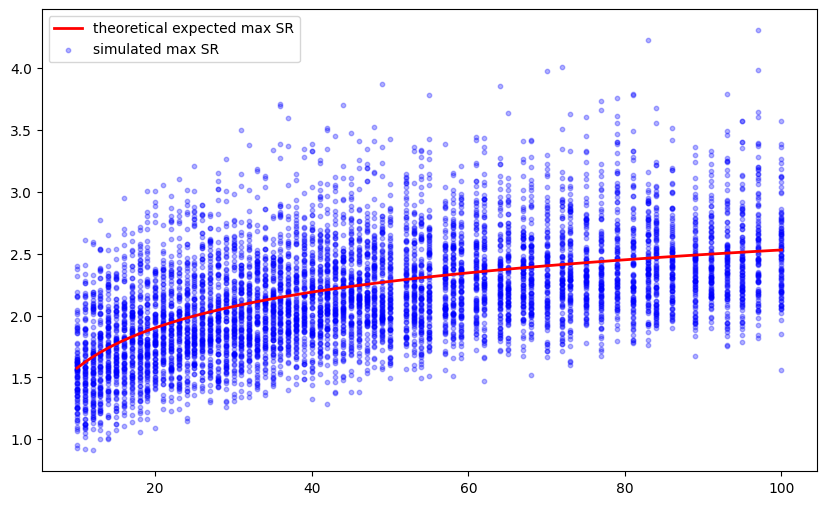

In [ ]:
# visualization

plt.figure(figsize=(10, 6))

# plot sr0 (theoretical line)
plt.plot(sr0.index, sr0.values, 
         color='red', 
         linewidth=2, 
         label='theoretical expected max SR')

# plot sr1 (simulated scatter)
plt.scatter(sr1['nTrials'], sr1['max{SR}'], 
            color='blue', 
            alpha=0.3,  # Semi-transparent points
            s=10,       # Point size
            label='simulated max SR')

plt.legend()

# while the true SR ~ N(0, 1)